# Sensor Calibration

This is an attempt to calibrate for the intensity of the laser, using Malus' Data. This has important consequences in determining the verdet constants.

Specifically, Malus' will give us a map of the intensity profile to the sensor. 

We know that at an incident power of 1mW the sensor generates a current of 0.6mA hence we can define the following relation:

$$k_p = \frac{0.6mA}{1mW}$$

Hence the voltage generated from the sensor is:

$$v_p = R k_p P(t)$$

where R is the resistance across the sensor, and P(t) is the incident power

We can use the diode equation to find the i-v characteristic of the photodiode.

$$I = I_0 \left( e^{V/V_0} - 1\right) - I_p$$


We can taylor expand around the center to find out about the photodiode

In [6]:
# Import the relevant libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.constants as consts
import os
from csvlib import *
from scipy.optimize import curve_fit
from scipy import optimize

# Display mpl in notebook format
%matplotlib inline

## Data collection


In [7]:
# read DATA

# open CSV files to numpy array
csvs = list_csv()   # Gets CSV files in a given directory --> list
# print(csvs)       # see list of CSV files

final=360
DATA = pd.read_csv(csvs[final])     # Gets the CSV file as a Pandas Data Frame

# the data as a np array
data = DATA.to_numpy().T        # Gets data as a numpy array
DATA                            # Prints pretty PANDAS data frame


,Angle,Voltage,Voltage_std
0,0,0.202959,0.003350
1,1,0.202459,0.003323
2,2,0.203485,0.003347
3,3,0.201608,0.003230
4,4,0.201677,0.003286
...,...,...,...
355,355,0.170765,0.003505
356,356,0.174575,0.003398
357,357,0.178441,0.003432
358,358,0.179148,0.003521


[0.0005927583504319495, 0.005737012220479879, 0.0031261055674588045, 0.000352072628129824]


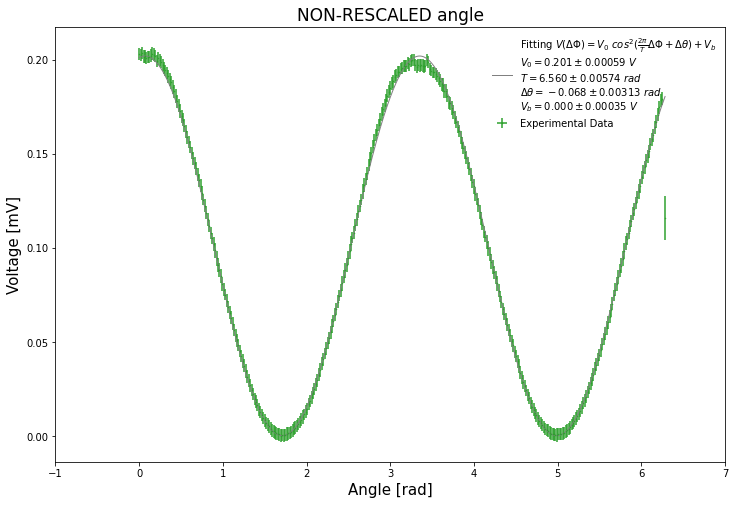

In [8]:
# NON-RESCALED Data fitting

# x =  deltha phi - angle between polarizer and plane of polarization of the light
# x_err = error from motor rotating polarizer
# xlin = equidistanced x array to plot the fit 

# y = voltage
# y_err = std dev of voltage (from oscilloscope)

x = data[0]*np.pi/180
x_err = 0# [2.5*np.pi/180]*len(x) 
# error bar of motor?

y = data[1]
y_err = data[2]

# x for fit
Npts = 1000
xlin = np.linspace(x[0],x[-1],Npts)

# Fit data with Malus's law
def fit(x,a,b,c,d):
    return a*np.cos(2*np.pi*x/b+c)**2+d

params, pcov = curve_fit(fit,x,y,p0=[0.2,2*np.pi,0,1])

errors = []
for i in range(len(params)):
    errors.append(np.sqrt(pcov[i][i]))
print(errors)

# Define the figure and plot parameters
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('NON-RESCALED angle',fontsize=17)
ax.set_xlabel('Angle [rad]',fontsize=15)
ax.set_ylabel('Voltage [mV]',fontsize=15)

# Plot the actual elements
ax.errorbar(x,y,yerr = y_err, xerr = x_err, color = 'C2',ms = 1, fmt = '.',label='Experimental Data')
#ax.plot(x,y,'.',color='C2',ms=3,label='Experimental data')
ax.plot(xlin,fit(xlin,*params), color = 'gray', lw = 1,
        label=r'Fitting $V(\Delta\Phi) = V_0\ cos^2(\frac{2\pi}{T}\Delta\Phi+\Delta\theta)+V_b$'+'\n'+
        r'$V_0=%5.3f \pm %1.5f\ V$'%(params[0],errors[0])+'\n'+
        r'$T=%5.3f \pm %1.5f\ rad$'%(params[1],errors[1])+'\n'+
        r'$\Delta\theta=%5.3f \pm %1.5f\ rad$'%(params[2],errors[2])+'\n'+
        r'$V_b=%5.3f \pm %1.5f\ V$'%(params[3],errors[3]))
ax.set_xlim(-1,7)
ax.legend(fontsize = 10,loc='best',frameon=False)
# ax.grid()

0
Angle-0.csv


(-0.2, 0.3)

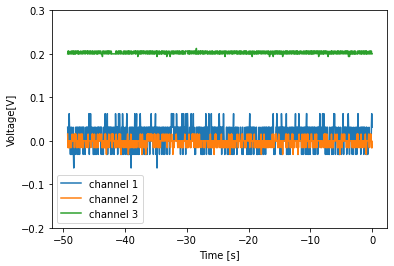

In [9]:
# import raw data per angle

# choose angle
angle = 0

# find index of file
csvs = list_csv() 
angles=[]
for i in range (len(csvs)):
    angles.append(str(csvs[i].split("-")[1]).split('.')[0])
index = list.index(angles,str(angle))
print(index)
print(csvs[index])
# get data
DATA_ang = pd.read_csv(csvs[index])     # Gets the CSV file as a Pandas Data Frame
data_angle = DATA_ang.to_numpy().T        # Gets data as a numpy array
#DATA_ang                            # Prints pretty PANDAS data frame

osci = plt.figure(figsize=(6,4))
ax_osci = osci.add_subplot(111)
ax_osci.set_xlabel("Time [s]")
ax_osci.set_ylabel("Voltage[V]")

ax_osci.plot(data_angle[0],data_angle[1],label='channel 1')
ax_osci.plot(data_angle[2],data_angle[3],label='channel 2')
ax_osci.plot(data_angle[4],data_angle[5],label='channel 3')
ax_osci.legend(loc='best')

ax_osci.set_ylim(-0.2,0.3)

In [10]:
# find angle shift
# for a range of angles find fit parameters when T = 2pi
# find the angle for which uncertainty on parameters = minimum

#  raw data
x = data[0]
y = data[1]
y_err = data[2]

# range of angles
angles = np.linspace(320,385,1000)
#print(angles)

# fit function with T = 2pi
def fit(x,a,c,d):
    return a*(np.cos(x+c)**2)+d

# store parameters and errors
params_list =[]
err_list =[]


for ang in angles:
    
    # rescale to angle 
    x_new = np.linspace(0,ang,len(x))
    x_new*=np.pi/180

    # find parameters and errors
    params, pcov = curve_fit(fit,x_new,y,p0=[0.2,0,1])
    errors = []
    for i in range(len(params)):
        errors.append(np.sqrt(pcov[i][i]))
        
    # store to list
    params_list.append(params)
    err_list.append(errors)
        
    # plot each fit (/for loop) on a separate figure:
    '''
    # Define the figure and plot parameters
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.set_title('A PLOT',fontsize=17)
    ax.set_xlabel('Angle [rad]',fontsize=15)
    ax.set_ylabel('Voltage [mV]',fontsize=15)

    # Plot the actual elements
    ax.errorbar(x_new,y,yerr = y_err, xerr = x_err, color = 'C2',ms = 1, fmt = '.',label='Experimental Data')
    #ax.plot(x_new,y,'.',color='C2',ms=3,label='Experimental data')
    ax.plot(x_new,fit(x_new,*params), color = 'gray', lw = 1,
            label=r'Fitting $V(\Delta\Phi) = V_0\ cos^2(\frac{2\pi}{T}\Delta\Phi+\Delta\theta)+V_b$'+'\n'+
            r'$V_0=%5.3f \pm %1.5f$'%(params[0],errors[0])+'\n'+
            r'$T=%5.3f \pm %1.5f$'%(params[1],errors[1])+'\n'+
            r'$\Delta\theta=%5.3f \pm %1.5f$'%(params[2],errors[2])
            #+'\n'+r'$V_b=%5.3f \pm %1.5f$'%(params[3],errors[3])
           )
    ax.set_xlim(-1,7)
    ax.legend(fontsize = 10,loc='best',frameon=False)
    '''
print("Done :)")
    


Done :)


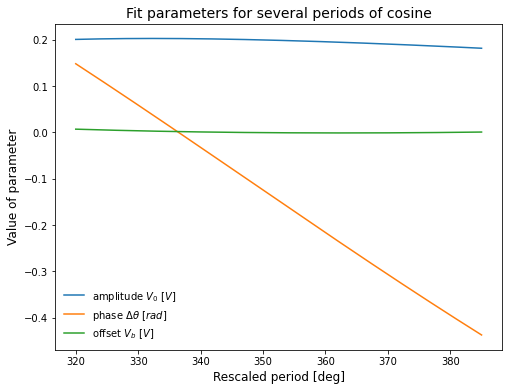

In [11]:
# plot obtained parameters

p = np.array(params_list).transpose()

# Define the figure and plot parameters
fig_params = plt.figure(figsize=(8,6))
ax_params = fig_params.add_subplot(111)
ax_params.set_title('Fit parameters for several periods of cosine',fontsize=14)
ax_params.set_xlabel('Rescaled period [deg]',fontsize=12)
ax_params.set_ylabel('Value of parameter',fontsize=12)


ax_params.plot(angles,p[0],label=r'amplitude $V_0\ [V]$')
ax_params.plot(angles,p[1],label=r'phase $\Delta\theta\ [rad]$')
ax_params.plot(angles,p[2],label=r'offset $V_b\ [V]$')


ax_params.legend(fontsize=10,loc='best',frameon=False)

343.8138138138138


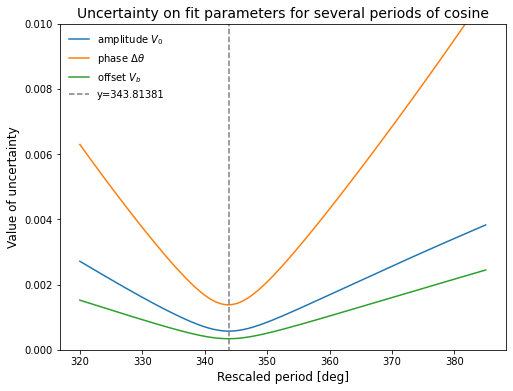

In [12]:
err = np.array(err_list).transpose()

# Define the figure and plot parameters
fig_err = plt.figure(figsize=(8,6))
ax_err = fig_err.add_subplot(111)
ax_err.set_title('Uncertainty on fit parameters for several periods of cosine',fontsize=14)
ax_err.set_xlabel('Rescaled period [deg]',fontsize=12)
ax_err.set_ylabel('Value of uncertainty',fontsize=12)

ax_err.plot(angles,err[0],label=r'amplitude $V_0$')
ax_err.plot(angles,err[1],label=r'phase $\Delta\theta$')
ax_err.plot(angles,err[2],label=r'offset $V_b$')


mins = []
for i in range(3):
    mins.append(angles[np.argmin(err[i])])
    
minimum = sum(mins)/len(mins)
print(minimum)

y_min= np.linspace(-0.01,0.02,1000)
x_min=np.array([minimum]*len(y_min))
ax_err.plot(x_min,y_min,label=r'y=%1.5f'%(minimum),ls='dashed',c='gray')
ax_err.set_ylim(0,0.01)

ax_err.legend(fontsize=10,loc='best',frameon=False)


[0.000577773946513742, 0.00535309060470871, 0.003045986619947087, 0.00034313837299227345]


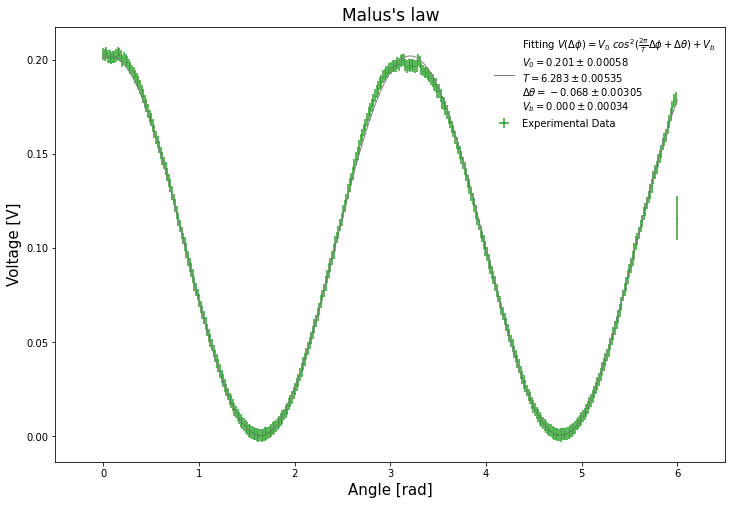

In [13]:
# RESCALED Data fitting

# x = theta
# x_err = error from scale on polarizer 
# xlin = equidistanced x array to plot the fit 

# y = voltage
# y_err = std dev of voltage (from oscilloscope)

x = data[0]
start = 0.
end = minimum
x_rescaled=np.linspace(start,end,len(x))

# to radians
x_rescaled*=np.pi/180
x_err = 0
# error bar of motor?

Npts = 1000
xlin = np.linspace(x_rescaled[0],x_rescaled[-1],Npts)

y = data[1]
y_err = data[2]

# Fit data with Malus's law
def fit(x,a,b,c,d):
    return a*np.cos(2*np.pi*x/b+c)**2+d


params, pcov = curve_fit(fit,x_rescaled,y,p0=[0.2,2*np.pi,0,1])

errors = []
for i in range(len(params)):
    errors.append(np.sqrt(pcov[i][i]))
print(errors)

# Define the figure and plot parameters
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('Malus\'s law',fontsize=17)
ax.set_xlabel('Angle [rad]',fontsize=15)
ax.set_ylabel('Voltage [V]',fontsize=15)

# Plot the actual elements
ax.errorbar(x_rescaled,y,yerr = y_err, xerr = x_err, color = 'C2',ms = 1, fmt = '.',label='Experimental Data')
#ax.plot(x,y,'.',color='C2',ms=3,label='Experimental data')
ax.plot(xlin,fit(xlin,*params), color = 'gray', lw = 1,
        label=r'Fitting $V(\Delta\phi) = V_0\ cos^2(\frac{2\pi}{T}\Delta\phi+\Delta\theta)+V_b$'+'\n'+
        r'$V_0=%5.3f \pm %1.5f$'%(params[0],errors[0])+'\n'+
        r'$T=%5.3f \pm %1.5f$'%(params[1],errors[1])+'\n'+
        r'$\Delta\theta=%5.3f \pm %1.5f$'%(params[2],errors[2])+'\n'+
        r'$V_b=%5.3f \pm %1.5f$'%(params[3],errors[3]))
ax.set_xlim(-0.5,6.5)
ax.legend(fontsize = 10,loc='best',frameon=False)
# ax.grid()

# Fit for the power decay

[0.000907385864488683, 0.005174736911639722, 0.002986767485186521, 0.00033175667430741703, 0.0024425038256944377]


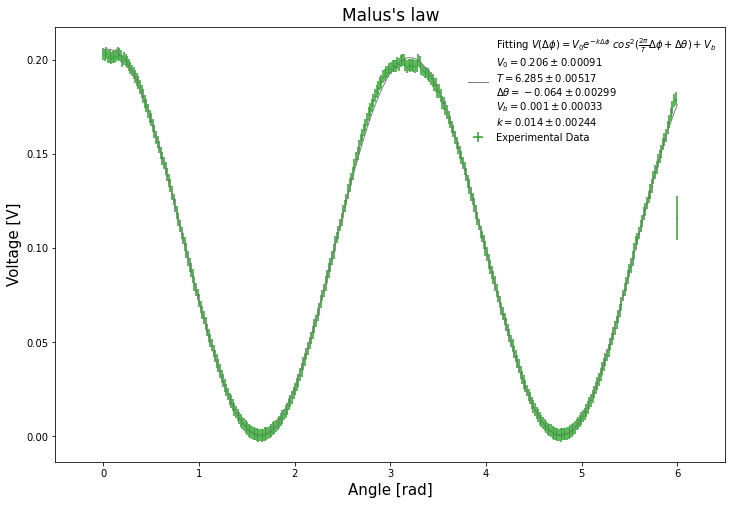

In [37]:
# RESCALED Data fitting

# x = theta
# x_err = error from scale on polarizer 
# xlin = equidistanced x array to plot the fit 

# y = voltage
# y_err = std dev of voltage (from oscilloscope)

x = data[0]
start = 0.
end = minimum
x_rescaled=np.linspace(start,end,len(x))

# to radians
x_rescaled*=np.pi/180
x_err = 0
# error bar of motor?

Npts = 1000
xlin = np.linspace(x_rescaled[0],x_rescaled[-1],Npts)

y = data[1]
y_err = data[2]

# Fit data with Malus's law
def fit(x,a,b,c,d,e):
    return (1-e*(x)**(1/2))*a*np.cos(2*np.pi*x/b+c)**2+d 


params, pcov = curve_fit(fit,x_rescaled,y,p0=[0.2,2*np.pi,0,1,1])

errors = []
for i in range(len(params)):
    errors.append(np.sqrt(pcov[i][i]))
print(errors)

# Define the figure and plot parameters
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('Malus\'s law',fontsize=17)
ax.set_xlabel('Angle [rad]',fontsize=15)
ax.set_ylabel('Voltage [V]',fontsize=15)

# Plot the actual elements
ax.errorbar(x_rescaled,y,yerr = y_err, xerr = x_err, color = 'C2',ms = 1, fmt = '.',label='Experimental Data')
#ax.plot(x,y,'.',color='C2',ms=3,label='Experimental data')
ax.plot(xlin,fit(xlin,*params), color = 'gray', lw = 1,
        label=r'Fitting $V(\Delta\phi) = V_0 e^{-k\Delta\phi}\ cos^2(\frac{2\pi}{T}\Delta\phi+\Delta\theta)+V_b$'+'\n'+
        r'$V_0=%5.3f \pm %1.5f$'%(params[0],errors[0])+'\n'+
        r'$T=%5.3f \pm %1.5f$'%(params[1],errors[1])+'\n'+
        r'$\Delta\theta=%5.3f \pm %1.5f$'%(params[2],errors[2])+'\n'+
        r'$V_b=%5.3f \pm %1.5f$'%(params[3],errors[3])+'\n'+
        r'$k = %5.3f \pm %1.5f$'%(params[4],errors[4]))
    
ax.set_xlim(-0.5,6.5)
ax.legend(fontsize = 10,loc='best',frameon=False)
# ax.grid()

In [ ]:
import numpy.fft as fft

F = fft.fft(fit_voltage)
Freq = fft.fftfreq(len(fit_voltage),fit_voltage[2]-fit_voltage[1])

plt.plot(Freq*np.pi,abs(F))
plt.xlim(0,1)